# Formatting Labelled Data

In [1]:
import pandas as pd

In [2]:
def grab_labelled_data(data_path, label_begins = 98): 
  labelled = pd.read_csv(data_path)
  label_begins = 98

  features = labelled.iloc[:, 2:label_begins] 
  labels = labelled.iloc[:, label_begins:]
  ids = labelled.iloc[:, :2]

  labels.columns = [x[10:] for x in labels.columns]

  features = features.join(ids)
  labels = labels.join(ids)

  features.columns.name = 'Time' 
  labels.columns.name = 'Time'

  features = features.pivot_table(index = ['Student ID', 'Date'])
  labels = labels.pivot_table(index = ['Student ID', 'Date'])

  features = pd.DataFrame(features.stack()).reset_index()
  labels = pd.DataFrame(labels.stack()).reset_index()

  time_stamps = features['Date'] + " " + features['Time']
  time_stamps = pd.to_datetime(time_stamps)

  features['Datetime'] = time_stamps
  labels['Datetime'] = time_stamps

  features = features.drop(columns = ['Date', 'Time'] ) 
  labels = labels.drop(columns = ['Date', 'Time'])

  features = features.pivot_table(index = ['Student ID', 'Datetime']) 
  labels = labels.pivot_table(index = ['Student ID', 'Datetime'])

  features.columns = ['Steps'] 
  labels.columns = ['Asleep']

  labelled_data = features.join(labels * 200)

  return labelled_data 

In [4]:
labelled = grab_labelled_data('./BMCM_steps_sleep.csv')
labelled

Steps  Asleep
Student ID Datetime                          
0          2021-10-01 00:00:00      0       0
           2021-10-01 00:15:00    107       0
           2021-10-01 00:30:00     18       0
           2021-10-01 00:45:00     73       0
           2021-10-01 01:00:00     10       0
...                               ...     ...
99         2021-10-31 22:45:00     56       0
           2021-10-31 23:00:00    450       0
           2021-10-31 23:15:00     56       0
           2021-10-31 23:30:00     11       0
           2021-10-31 23:45:00      4       0

[297600 rows x 2 columns]

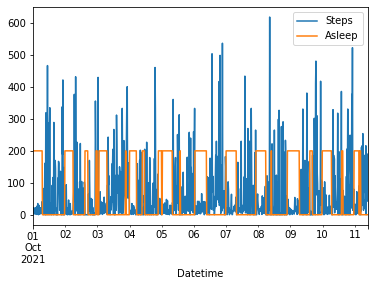

In [18]:
labelled[['Steps', 'Asleep']].loc[60].iloc[:1000].plot()

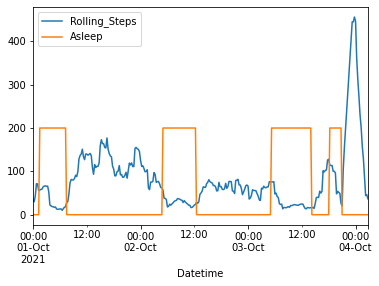

In [ ]:
labelled_data[['Rolling_Steps', 'Asleep']].loc[5].iloc[:300].plot()

In [19]:
import numpy as np
as_strided = np.lib.stride_tricks.as_strided
win = 7
v = as_strided(labelled['Steps'], (len(labelled) - (win - 1), win), (labelled['Steps'].values.strides * 2))

In [26]:
labels = labelled['Asleep'][3:297597].to_numpy()
labels = labels.reshape((1, 297594))
v = np.concatenate((v, labels.T), axis=1)
v

ValueError: ignored

In [ ]:
v = pd.DataFrame(v, columns = ['t-4','t-3','t-2','t-1', 't', 't+1', 't+2', 'asleep'])
v

,t-4,t-3,t-2,t-1,t,t+1,t+2,asleep
0,0,107,18,73,10,83,1,0
1,107,18,73,10,83,1,25,0
2,18,73,10,83,1,25,9,0
3,73,10,83,1,25,9,8,200
4,10,83,1,25,9,8,26,200
...,...,...,...,...,...,...,...,...
297589,246,14,35,8,6,11,56,0
297590,14,35,8,6,11,56,450,0
297591,35,8,6,11,56,450,56,0
297592,8,6,11,56,450,56,11,0


In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['t-4','t-3','t-2','t-1', 't', 't+1', 't+2']
x = v.loc[:, features].values # Separating out the features
y = v.loc[:,['asleep']].values # Separating out the target
x = StandardScaler().fit_transform(x) # Standardizing the features

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, v[['asleep']]], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,asleep
0,-0.494531,-0.043642,-0.133317,0
1,-0.481357,-0.166984,-0.023253,0
2,-0.600270,-0.100867,-0.144875,0
3,-0.626654,-0.173001,-0.049034,200
4,-0.690299,-0.082692,-0.024597,200
...,...,...,...,...
297589,-0.450037,-0.376944,0.421174,0
297590,-0.206565,0.829121,0.789584,0
297591,-0.067001,0.786074,0.283173,0
297592,-0.026594,0.487397,-0.616520,0


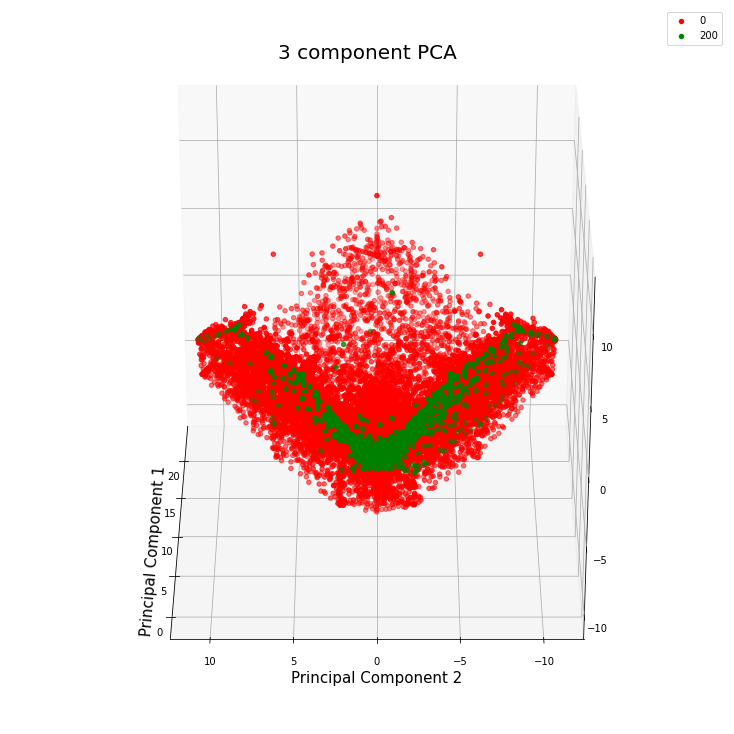

In [ ]:
Simport matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0, 200]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['asleep'] == target
    ax.scatter3D(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color)
ax.legend(targets)
ax.grid()

for i in range(180, 360, 45):
    ax.view_init(None, i)
    plt.show()

In [ ]:
X = finalDf[['principal component 1', 'principal component 2']].to_numpy()
X

array([[-0.49453113, -0.04364156],
       [-0.48135728, -0.16698405],
       [-0.60026969, -0.10086694],
       ...,
       [-0.06700087,  0.78607391],
       [-0.02659363,  0.48739713],
       [-0.00699197, -0.00364332]])

In [ ]:
y = finalDf['asleep'].to_numpy()
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
from sklearn.linear_model import SGDClassifier
reg = SGDClassifier(loss="hinge", penalty="l2", max_iter=20).fit(X, y)
reg.score(X, y)

0.8499969757454787

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
X_poly = PolynomialFeatures(interaction_only=True).fit_transform(X).astype(float)
clf_poly = Perceptron(fit_intercept=False, max_iter=10, tol=None, shuffle=False).fit(X_poly, y)
clf_poly.score(X_poly, y)

0.7892733052413691

In [ ]:
from sklearn import svm
clf_svm = svm.SVC()
clf_svm.fit(X, y)
clf_svm.score(X, y)

# Formatting Unlabelled Data

In [ ]:
def grab_unlabelled_data(data_path): 
  unlabelled = pd.read_csv(data_path) 
  unlabelled = unlabelled.pivot_table(index = ['Student ID', 'Date'])
  unlabelled.columns.name = 'Time'
  unlabelled = pd.DataFrame(unlabelled.stack())
  unlabelled = unlabelled.reset_index()
  unlabelled['Datetime'] = pd.to_datetime(unlabelled['Date'] + ' ' + unlabelled['Time'])
  unlabelled = unlabelled.drop(columns = ['Date', 'Time'])
  #unlabelled = unlabelled.pivot_table(index = ['Student ID', 'Datetime'])
  #unlabelled.columns = ['Steps']

  return unlabelled 

In [ ]:
unlabelled = grab_unlabelled_data('./BMCM_steps.csv')
unlabelled[0] = unlabelled[0].rolling(12).mean()
unlabelled = unlabelled[11:]
unlabelled

,Student ID,0,Datetime
11,100,47.666667,2021-10-01 11:45:00
12,100,42.666667,2021-10-01 12:00:00
13,100,53.416667,2021-10-01 12:15:00
14,100,55.416667,2021-10-01 12:30:00
15,100,55.416667,2021-10-01 12:45:00
...,...,...,...
1190395,499,65.916667,2021-10-31 08:45:00
1190396,499,67.000000,2021-10-31 09:00:00
1190397,499,73.583333,2021-10-31 09:15:00
1190398,499,115.833333,2021-10-31 09:30:00


In [ ]:
import numpy as np
as_strided = np.lib.stride_tricks.as_strided
win = 7
v = as_strided(unlabelled[0], (len(unlabelled) - (win - 1), win), (unlabelled[0].values.strides * 2))
v

array([[ 47.66666667,  42.66666667,  53.41666667, ...,  55.41666667,
         29.58333333,  29.41666667],
       [ 42.66666667,  53.41666667,  55.41666667, ...,  29.58333333,
         29.41666667,  29.        ],
       [ 53.41666667,  55.41666667,  55.41666667, ...,  29.41666667,
         29.        ,  26.08333333],
       ...,
       [ 68.75      ,  66.5       ,  69.5       , ...,  65.91666667,
         67.        ,  73.58333333],
       [ 66.5       ,  69.5       ,  65.16666667, ...,  67.        ,
         73.58333333, 115.83333333],
       [ 69.5       ,  65.16666667,  65.91666667, ...,  73.58333333,
        115.83333333, 114.91666667]])

In [ ]:
v = pd.DataFrame(v, columns = ['t-4','t-3','t-2','t-1', 't', 't+1', 't+2'])
v

,t-4,t-3,t-2,t-1,t,t+1,t+2
0,47.666667,42.666667,53.416667,55.416667,55.416667,29.583333,29.416667
1,42.666667,53.416667,55.416667,55.416667,29.583333,29.416667,29.000000
2,53.416667,55.416667,55.416667,29.583333,29.416667,29.000000,26.083333
3,55.416667,55.416667,29.583333,29.416667,29.000000,26.083333,32.250000
4,55.416667,29.583333,29.416667,29.000000,26.083333,32.250000,26.916667
...,...,...,...,...,...,...,...
1190378,36.000000,36.500000,68.750000,66.500000,69.500000,65.166667,65.916667
1190379,36.500000,68.750000,66.500000,69.500000,65.166667,65.916667,67.000000
1190380,68.750000,66.500000,69.500000,65.166667,65.916667,67.000000,73.583333
1190381,66.500000,69.500000,65.166667,65.916667,67.000000,73.583333,115.833333


In [ ]:
from sklearn.preprocessing import StandardScaler
features = ['t-4','t-3','t-2','t-1', 't', 't+1', 't+2'] # Separating out the features
x = v.loc[:, features].values # Separating out the target
x = StandardScaler().fit_transform(x) # Standardizing the features

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf


,principal component 1,principal component 2
0,-0.755517,0.102726
1,-0.805975,0.156247
2,-0.853851,0.215163
3,-0.913080,0.170218
4,-0.987592,0.105881
...,...,...
1190378,-0.505922,-0.194284
1190379,-0.424854,-0.106197
1190380,-0.333109,-0.014525
1190381,-0.215250,-0.201616


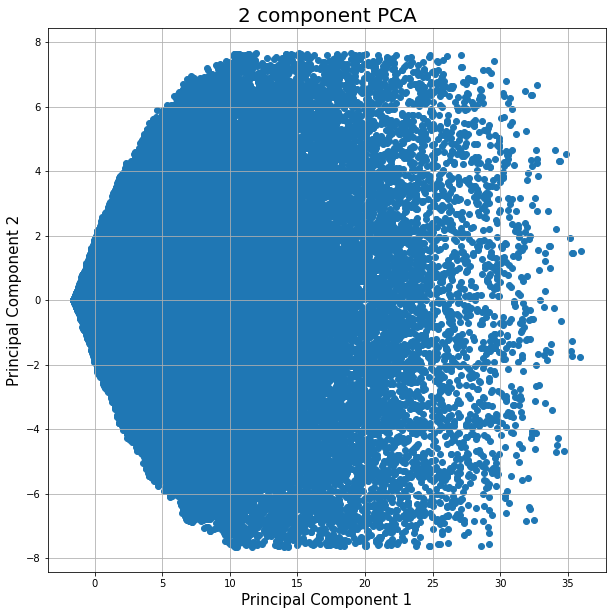

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()

In [ ]:
v_lab = as_strided(unlabelled[0], (len(unlabelled) - (win - 1), win), (unlabelled[0].values.strides * 2))
v